# Open Source Operational Energy Yield Analysis (Oh SOe YeAh)

This python notebook demonstrates the use of the osoeya package to calculate the long-term generation of an asset using historical operational data and resource data.

## Next steps
1. DONE - Remove outliers in correlation
1. DONE - Export to excel
1. DONE - Concurrent data included in main df, rather than separate
1. DONE - Ability for manual exclusions
1. DONE - Validate methodology in excel
1. Rename columns as required
1. Add additional markdown
1. Remove example manual filters!

## Improvements
These are not listed in any particular order at the moment.

### Data
1. PARTIAL - EIA download for all plants to speed up results
1. MERRA2 included as well
1. Cover wind and solar
1. Link to OSM to get turbine level layout
1. Update information on wikidata
1. Reporting dodgy data
1. Check EIA asset capacity has not changed over time
1. Extend to other open generation datasets (e.g. UK, Europe, Australia, Brazil)

### Methodology
1. Review other fits: https://realpython.com/linear-regression-in-python/
1. Degradation analysis (important for solar)
1. Time-series analysis to check data consistency
1. Validation
1. Fringe case of no data in a given month - utilise synthesised data instead
1. Ability for manual inputs of generation and availability

### Usability
1. Simple front-end
1. Map of assets covered
1. Examples
1. Documentation
1. Prettify results :)

## Methodology

1. Load in the required data
1. 
1.
1.
1.

## Load libraries and environment variables

For downloading the ERA5 resource data from the CDS registration is required. Please see instructions for registration and setting up the API here: https://cds.climate.copernicus.eu/api-how-to

For downloading the EIA plant generation data registration is required. See here: https://www.eia.gov/opendata/register.php. The API password should then be added to a .env file in the main OSOEYA directory as follows: EIA_API_KEY = "xxxx"

In [1]:
# load system packages
import os
from pathlib import Path

# load custom packages (requirements)
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# load local packages
from downloader import get_era5_monthly, get_EIA_plant_information, get_EIA_plant_generation

# load environment variables
load_dotenv()
EIA_API_KEY = os.environ["EIA_API_KEY"]



## Get data

This codes 
1. Gets EIA plant information
1. Allows the user to select a plant for review
1. Downloads the EIA generation data for that asset
1. Downloads and accesses the long-term ERA5 resource data for the asset

The first time this code is run this will take a while, as it downloads a significant amount of data (~500MB for ERA5), for local storage and future rapid access.

In [2]:
# get EIA plant information for wind assets
plant_info_file=Path("data/plant_list.csv").resolve()
if not plant_info_file.is_file():
    df_plant = get_EIA_plant_information(EIA_API_KEY)
    df_plant.to_csv(plant_info_file)
else:
    df_plant = pd.read_csv(plant_info_file)

df_plant.head(5)



,Unnamed: 0,period,stateid,stateName,sector,sectorName,entityid,entityName,plantid,plantName,...,balancing-authority-name,status,statusDescription,nameplate-capacity-mw,longitude,latitude,operating-year-month,planned-retirement-year-month,unit,nameplate-capacity-mw-units
0,0,2023-05,TX,Texas,ipp-non-chp,IPP Non-CHP,58998,Chapman Ranch Wind LLC,59193,Chapman Ranch Wind I,...,"Electric Reliability Council of Texas, Inc.",OP,Operating,236.0,-97.500833,27.592500,2017-10,NaN,NaN,MW
1,1,2023-05,IL,Illinois,ipp-non-chp,IPP Non-CHP,56421,Blackstone Wind Farm II LLC,57113,Blackstone Wind Farm II LLC,...,"PJM Interconnection, LLC",OP,Operating,200.0,-88.530000,41.140600,2010-08,NaN,NaN,MW
2,2,2023-05,IL,Illinois,ipp-non-chp,IPP Non-CHP,56418,Blackstone Wind Farm LLC,57110,Blackstone Wind Farm LLC,...,"PJM Interconnection, LLC",OP,Operating,106.0,-88.623300,41.150800,2009-10,NaN,NaN,MW
3,3,2023-05,NM,New Mexico,ipp-non-chp,IPP Non-CHP,57421,"Chopin Wind, LLC",58465,Broadview Energy Prime 2 LLC,...,Southwest Power Pool,OP,Operating,9.9,-103.305000,34.728056,2014-02,NaN,NaN,MW
4,4,2023-05,NM,New Mexico,ipp-non-chp,IPP Non-CHP,57421,"Chopin Wind, LLC",58464,Broadview Energy Prime LLC,...,Southwest Power Pool,OP,Operating,9.9,-103.325000,34.746944,2014-02,NaN,NaN,MW


In [3]:
# select an EIA plant for analysis
selected_plant = df_plant.iloc[1]
print(selected_plant)

Unnamed: 0                                                 1
period                                               2023-05
stateid                                                   IL
stateName                                           Illinois
sector                                           ipp-non-chp
sectorName                                       IPP Non-CHP
entityid                                               56421
entityName                       Blackstone Wind Farm II LLC
plantid                                                57113
plantName                        Blackstone Wind Farm II LLC
generatorid                                            GEN 1
technology                              Onshore Wind Turbine
energy_source_code                                       WND
energy-source-desc                                      Wind
prime_mover_code                                          WT
balancing_authority_code                                 PJM
balancing-authority-name

In [4]:
# get the EIA generation for the selected plant

plant_data_file = Path(f"data/plant_generation_{selected_plant['plantid']}.csv").resolve()

if not plant_data_file.is_file():
    df_generation = get_EIA_plant_generation(EIA_API_KEY,plantCode=selected_plant["plantid"])
    df_generation.to_csv(plant_data_file)

else:
    df_generation = pd.read_csv(plant_data_file)

# set index to converted datetime
df_generation = df_generation.set_index("period")
df_generation.index = pd.to_datetime(df_generation.index)

print(df_generation)

            Unnamed: 0  plantCode                    plantName fuel2002  \
period                                                                    
2021-12-01           0      57113  Blackstone Wind Farm II LLC      WND   
2021-11-01           1      57113  Blackstone Wind Farm II LLC      WND   
2021-10-01           2      57113  Blackstone Wind Farm II LLC      WND   
2021-09-01           3      57113  Blackstone Wind Farm II LLC      WND   
2021-08-01           4      57113  Blackstone Wind Farm II LLC      WND   
...                ...        ...                          ...      ...   
2010-12-01         132      57113  Blackstone Wind Farm II LLC      WND   
2010-11-01         133      57113  Blackstone Wind Farm II LLC      WND   
2010-10-01         134      57113  Blackstone Wind Farm II LLC      WND   
2010-09-01         135      57113  Blackstone Wind Farm II LLC      WND   
2010-08-01         136      57113  Blackstone Wind Farm II LLC      WND   

           fuelTypeDescr

In [5]:
# get era5 data for the selected plant

df_era5 = get_era5_monthly(
    lat=selected_plant["latitude"],
    lon=selected_plant["longitude"]%360,
    save_pathname="data",
    save_filename=f"era5_monthly_plant_{selected_plant['plantid']}",
    data_pathname="data/era5_monthly",
    data_filename="era5_monthly",
    start_date="2000-01",
)

print(df_era5)

            windspeed_ms
datetime                
2000-01-01      4.219223
2000-02-01      4.407962
2000-03-01      3.918223
2000-04-01      3.929246
2000-05-01      4.040654
...                  ...
2023-04-01      4.373532
2023-05-01      3.557866
2023-06-01      3.409114
2023-07-01      2.631998
2023-08-01      3.138621

[284 rows x 1 columns]


In [6]:
# combine wind speed and generation into single dataframe
df = pd.concat([df_era5[["windspeed_ms"]],df_generation[["generation","gross-generation"]]],axis=1)

# add month number column
df["month"] = df.index.to_series().dt.month

# add days in month column
df["days-in-month"] = df.index.to_series().dt.days_in_month

# add availability column
df["availability-reported"] = df["generation"]/df["gross-generation"]

## Exclusions from long-term analysis

Where data is not representative of the long-term, it can be manually excluded. For example this could be due to plant ramp up, acts of god, or other rare events that are unlikely to occur in the future.

In [7]:
# any dates that are not representative of long-term performance can be excluded here
# e.g. df.loc["2014-01-01","exclude-from-long-term"] = True
df["exclude-from-long-term"] = False
df.loc["2014-01-01","exclude-from-long-term"] = True

In [8]:
# add filtered generation column
df["generation-filtered"] = df["generation"][df["exclude-from-long-term"]==False]
df["gross-generation-filtered"] = df["gross-generation"][df["exclude-from-long-term"]==False]

# add normalised generation column
df["generation-normalised"] = df["gross-generation-filtered"]*30/df["days-in-month"]

# add concurrent generation normalised column
df["concurrent-generation-normalised"] = df["generation-normalised"][df["windspeed_ms"].notnull() & df["generation-normalised"].notnull()]

# add concurrent windspeed
df["concurrent-windspeed_ms"] = df["windspeed_ms"][df["concurrent-generation-normalised"].notnull()]

print(df.dropna())


            windspeed_ms  generation  gross-generation  month  days-in-month  \
2010-08-01      2.507124     2877.00           2877.00      8             31   
2010-09-01      3.842653    23628.00          23628.00      9             30   
2010-10-01      3.913650    39593.00          39593.00     10             31   
2010-11-01      4.162776    59506.00          59551.00     11             30   
2010-12-01      3.921220    50388.00          50505.00     12             31   
...                  ...         ...               ...    ...            ...   
2021-08-01      2.698300    22447.84          22503.87      8             31   
2021-09-01      3.693215    39964.27          40064.02      9             30   
2021-10-01      3.651588    43604.64          43713.48     10             31   
2021-11-01      4.191844    58228.13          58373.48     11             30   
2021-12-01      4.225758    59986.34          60136.07     12             31   

            availability-reported  excl

## Correlation outliers

Certain events may cause some months to appear as outliers in the correlation. These may still be expected to reoccur in the future, but adversely affect the correlation. Typical examples are where the availability has been incorrectly reported, and so the gross generation is underestimated. In this case they can be excluded here. If however the outliers are considered as exceptional "one-off" events, that are unlikely to occur in the future, then these should be applied as an exclusion to the long-term analysis.

In [9]:
# detect correlation outliers and filter out

# apply linear regression
res = stats.linregress(x=df["concurrent-windspeed_ms"].dropna(),y=df["concurrent-generation-normalised"].dropna())

print("Linear fit with no filtering")
print(f"Slope: {res.slope}")
print(f"Intercept: {res.intercept}")
print(f"R-squared: {res.rvalue**2:.6f}")

# synthesise generation
df["concurrent-generation-synthesised-no-filter"] = res.intercept + res.slope*df["concurrent-windspeed_ms"]

# detect correlation outliers
df["residuals"] = df["concurrent-generation-normalised"]-df["concurrent-generation-synthesised-no-filter"]
df["correlation-outlier"] = df["residuals"].abs() > 3*df["residuals"].std()

Linear fit with no filtering
Slope: 23833.320782454488
Intercept: -48512.97496018141
R-squared: 0.898895


In [11]:
# any further data points that you wish to exclude from the correlation can be done so here
# e.g. df.loc["2010-08-01","correlation-outlier"] = True
df.loc["2010-08-01","correlation-outlier"] = True

In [12]:
# filter data for the improved correlation fit
df["concurrent-generation-normalised-filtered"] = df["concurrent-generation-normalised"][~df["correlation-outlier"]]
df["concurrent-windspeed_ms-filtered"] = df["concurrent-windspeed_ms"][~df["correlation-outlier"]]

In [14]:
# apply linear regression
res = stats.linregress(x=df["concurrent-windspeed_ms-filtered"].dropna(),y=df["concurrent-generation-normalised-filtered"].dropna())

print("Linear fit with filtering")
print(f"Slope: {res.slope}")
print(f"Intercept: {res.intercept}")
print(f"R-squared: {res.rvalue**2:.6f}")

# synthesise the generation
df["generation-synthesised"] = res.intercept + res.slope*df["windspeed_ms"]
df["concurrent-generation-synthesised"] = res.intercept + res.slope*df["concurrent-windspeed_ms"]

Linear fit with filtering
Slope: 23940.99739010378
Intercept: -48572.36781575804
R-squared: 0.920173


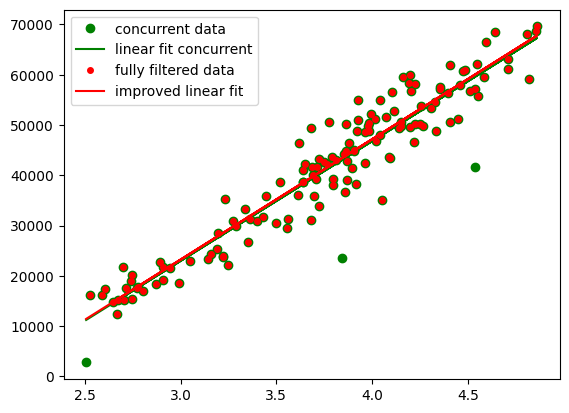

In [15]:
# plot outliers for review

df_filtered = df.loc[df["correlation-outlier"]==False] 

plt.plot(df["windspeed_ms"], df["concurrent-generation-normalised"], 'go', label='concurrent data')
plt.plot(df["windspeed_ms"], df["concurrent-generation-synthesised-no-filter"], 'g', label='linear fit concurrent')
plt.plot(df["windspeed_ms"], df["concurrent-generation-normalised-filtered"], 'ro', markersize=4, label='fully filtered data')
plt.plot(df["windspeed_ms"], df["concurrent-generation-synthesised"], 'r', label='improved linear fit')
plt.legend()

## Mean of Monthly Means

In [16]:
# mean of monthly means
momm = df.groupby("month").mean()

# long-term resource adjustment
momm["resource-adjustment"] = momm["generation-synthesised"]/momm["concurrent-generation-synthesised"]

print(momm[["generation-normalised","generation-synthesised","concurrent-generation-synthesised","resource-adjustment"]])

       generation-normalised  generation-synthesised  \
month                                                  
1               50736.765484            51301.519531   
2               52782.206326            52772.628906   
3               52868.677126            51614.406250   
4               55235.773636            56339.363281   
5               40477.209677            44419.152344   
6               31309.899091            32331.281250   
7               19143.197947            20545.419922   
8               15984.597581            18957.781250   
9               28639.444167            31197.966797   
10              42480.273387            46333.460938   
11              56209.232500            52073.218750   
12              49408.741935            49574.871094   

       concurrent-generation-synthesised  resource-adjustment  
month                                                          
1                           49108.671875             1.044653  
2                      

In [17]:
# long-term monthly
momm["reported-availability"] = momm["generation-filtered"]/momm["gross-generation-filtered"]
momm["gross-generation-long-term"] = momm["gross-generation-filtered"]*momm["resource-adjustment"]
momm["net-generation-long-term"] = momm["gross-generation-long-term"]*momm["reported-availability"]

print(momm[["gross-generation","gross-generation-filtered","resource-adjustment","gross-generation-long-term","reported-availability","net-generation-long-term"]])

       gross-generation  gross-generation-filtered  resource-adjustment  \
month                                                                     
1          54580.719091               52427.991000             1.044653   
2          49736.621818               49736.621818             0.991164   
3          54630.966364               54630.966364             1.008505   
4          55235.773636               55235.773636             1.027235   
5          41826.450000               41826.450000             1.033696   
6          31309.899091               31309.899091             0.964063   
7          19781.304545               19781.304545             1.056181   
8          16517.417500               16517.417500             1.178353   
9          28639.444167               28639.444167             0.945563   
10         43896.282500               43896.282500             0.989577   
11         56209.232500               56209.232500             0.991775   
12         51055.700000  

## P50 estimate

In [24]:
# P50 estimate
p50 = momm[["generation","gross-generation","gross-generation-filtered","gross-generation-long-term","net-generation-long-term"]].sum()
p50["resource-adjustment"] = p50["gross-generation-long-term"]/p50["gross-generation-filtered"]
p50["availability"] = p50["net-generation-long-term"]/p50["gross-generation-long-term"]
p50["r-squared"] = res.rvalue**2
print(p50)

generation                    502144.017879
gross-generation              503419.811212
gross-generation-filtered     501267.083121
gross-generation-long-term    510424.733910
net-generation-long-term      509107.341123
resource-adjustment                1.018269
availability                       0.997419
r-squared                          0.920173
dtype: float64


## Save results

In [19]:
# export results to excel

save_pathname = "results"

save_pathname = Path(save_pathname).resolve()

if not save_pathname.exists():
    save_pathname.mkdir()

outfile = save_pathname / f"result_plant_{selected_plant['plantid']}.xlsx"


with pd.ExcelWriter(outfile) as writer:  

    df.sort_index(ascending=False).to_excel(writer, sheet_name='monthly_data')

    momm.to_excel(writer, sheet_name='momm')

    p50.to_excel(writer, sheet_name='p50')

In [20]:
# from sklearn.neighbors import LocalOutlierFactor
# import numpy as np

# clf = LocalOutlierFactor(n_neighbors=2)
# clf.fit_predict(df_concurrent)
# df_concurrent["clf"]=clf.negative_outlier_factor_
# print(df_concurrent)
# df_concurrent.to_clipboard()
#np.mean(np.std(clf.negative_outlier_factor_))-5*np.std(clf.negative_outlier_factor_)

In [21]:

# fig, ax = plt.subplots(figsize=(20,10)) 
# df.plot(y = "generation", ax = ax) 
# df.plot(y = "gross-generation", ax = ax) 
# df.plot(y = "windspeed_ms", ax = ax, secondary_y = True) 
# plt.show()

#fig, ax = plt.subplots(figsize=(20,10)) 
#df.plot.scatter(x="windspeed_ms",y="generation-normalised",ax=ax)


In [22]:
#from sklearn.cluster import DBSCAN

# clustering = DBSCAN(eps=3, min_samples=2).fit(df_concurrent[["windspeed_ms","generation-normalised"]])

# print(clustering.labels_)